<a href="https://colab.research.google.com/github/lanyu0322/pedestrian_firstdraft_figures/blob/master/total_count_map%26standardized_wamp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from scipy.ndimage.filters import uniform_filter as uf

# -- install geopandas
try:
  import geopandas as gp
except:
  !pip install geopandas

In [ ]:
# -- read in the parameters from 4 pop fit
fname = os.path.join("drive", "My Drive", "lwir", "data", "4_pop_fit", 
                     "4pop_para.csv")
parr = pd.read_csv(fname)
parr

,m1,m2,m3,sd1,sd2,sd3,scl1,scl2,scl3,wamp,off,lat,lon,rstrant,parkarea,sratio,w_manhattan,r_manhattan,f
0,33.851576,55.863277,72.488448,3.918574,5.293415,5.114973,15.378522,8.962518,24.905331,0.003154,-1.350430,40.761268,-73.983564,180,0.000000,0.444968,19861.575731,686.304649,0.460344
1,30.868134,60.345814,75.860053,6.938228,8.000000,3.259189,29.987991,20.302354,11.055431,0.003885,-1.670593,40.770207,-73.986869,8,0.000000,0.989311,3871.237562,1712.178205,1.426865
2,36.113706,54.646832,73.313144,6.249101,8.000000,5.752984,32.832547,21.235017,21.908970,0.002501,-1.455431,40.718427,-73.994830,201,58445.164287,0.775829,3115.066002,1024.629008,1.031019
3,33.243215,50.212952,70.062325,4.659590,7.376667,8.000000,30.394023,25.371925,41.035492,0.001218,-1.331376,40.786516,-73.952456,36,19998.479164,0.710405,664.869474,2083.624285,2.936730
4,32.291000,50.613489,80.000000,5.238269,8.000000,8.000000,12.567800,7.314054,11.697363,0.005499,-1.786069,40.752424,-74.000899,10,27738.524376,0.602844,600.262988,114.241471,0.717577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,34.037069,51.881363,70.396683,4.598634,3.949852,8.000000,14.486425,10.025589,20.996413,0.003841,-1.493669,40.728600,-74.005356,75,45502.597890,0.565095,4789.079473,619.321194,0.638173
112,29.228780,48.527924,79.664681,6.109479,8.000000,2.181805,22.589535,41.490851,5.265512,0.002834,-1.474788,40.807061,-73.933681,0,233456.280673,2.979054,204.270486,33.049144,3.461039
113,33.755630,51.192093,72.038002,5.009737,4.035090,4.868150,27.709168,10.770061,17.902706,0.003312,-1.466665,40.761216,-73.957815,5,22530.378565,0.472248,4741.542367,1805.796279,0.652102
114,33.788771,51.541255,69.319898,5.326885,6.808593,7.190719,25.064411,35.537405,37.510759,0.000890,-1.258346,40.702389,-74.012806,88,119851.579490,1.135831,17701.876761,426.143228,1.163174


In [ ]:
# -- sub-select Manhattan
bpath = os.path.join("drive", "My Drive", "lwir", "data", "boro_boundaries")
bname = "Borough Boundaries.geojson"
boros = gp.read_file(os.path.join(bpath, bname))
boros = boros[boros.boro_name == "Manhattan"]

# -- set the parks geometries file name
dpath = os.path.join("drive", "My Drive", "lwir", "data", "parks", "properties")
fname = "geo_export_5b605687-0f81-4fe4-9fb7-ec27cd43ab5f.shp"

# -- load the parks geometries and convert to NY State Plane
parks = gp.read_file(os.path.join(dpath, fname))
parks_m = parks[parks.borough == "M"]

No handles with labels found to put in legend.


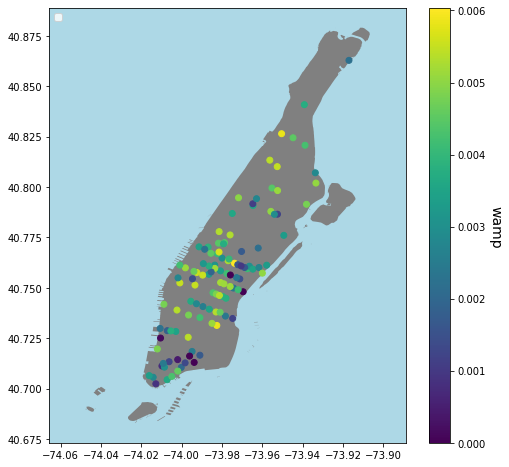

In [ ]:
# -- create a wamp plot of 4 population fit 
fig, ax = plt.subplots(figsize=[8, 8])
boros.plot(color="grey", ax=ax, legend=True)
#parks_m.plot(color="orange", ax=ax, legend=True)
sc = ax.scatter(parr["lon"], parr["lat"], c=parr["wamp"])
#sc = ax.scatter(camera.iloc[106]["lon"], camera.iloc[106]["lat"], color = "red", label='Comparison of Tourist Behavior')
fig.colorbar(mappable=sc, ax=ax)
ax.legend(loc='upper left')
ax.set_facecolor("lightblue")
ax.axis("equal")
#ax.set_title("wamp of 4 population fit")
fig.text(0.9, 0.5, "wamp", ha="center", 
         va="center", rotation=-90, fontsize=14)

outfile = os.path.join("drive", "My Drive", "lwir", "output", 
                       "wamp of 4 population fit.png")
fig.savefig(outfile)


In [ ]:
parr

,m1,m2,m3,sd1,sd2,sd3,scl1,scl2,scl3,wamp,off,lat,lon,rstrant,parkarea,sratio,w_manhattan,r_manhattan,f
0,33.904395,55.488926,72.467277,3.905416,5.196401,5.489595,25.926155,16.290366,46.271962,0.004927,0.954666,40.761268,-73.983564,180,0.000000,0.451268,19861.575731,686.304649,0.466862
1,29.726637,60.754319,75.602532,6.276174,2.000000,3.217609,4.067507,0.746344,1.248451,0.000821,-0.051532,40.770207,-73.986869,8,0.000000,0.280794,3871.237562,1712.178205,0.404984
2,35.946244,54.363061,73.422752,6.169034,8.000000,5.714196,54.753768,30.349075,33.569916,0.005309,-0.094967,40.718427,-73.994830,201,58445.164287,0.687224,3115.066002,1024.629008,0.913270
3,33.221328,50.239117,70.127408,4.628368,7.442014,8.000000,19.322445,16.022023,25.870235,0.000840,0.126589,40.786516,-73.952456,36,19998.479164,0.709054,664.869474,2083.624285,2.931147
4,32.370314,51.720075,80.000000,5.193480,8.000000,8.000000,14.260991,9.510312,16.160903,0.006157,-0.065108,40.752424,-74.000899,10,27738.524376,0.625228,600.262988,114.241471,0.744221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,32.909323,50.650062,80.000000,4.271507,2.000000,8.000000,11.884143,2.944952,6.572555,0.006022,-0.044978,40.728600,-74.005356,75,45502.597890,0.319120,4789.079473,619.321194,0.360389
112,29.236315,48.597722,79.786679,6.062491,8.000000,2.308522,1.984760,3.712308,0.505734,0.000248,0.045705,40.807061,-73.933681,0,233456.280673,2.981183,204.270486,33.049144,3.463512
113,33.846257,51.323313,72.105884,4.987488,4.380156,5.458403,5.044572,2.339576,3.922614,0.000520,0.044570,40.761216,-73.957815,5,22530.378565,0.521808,4741.542367,1805.796279,0.720537
114,33.764914,51.503434,69.145278,5.338492,6.627297,7.174253,75.325907,99.890250,107.951338,0.003651,0.204601,40.702389,-74.012806,88,119851.579490,1.090045,17701.876761,426.143228,1.116286


# comparison of tourist component


In [ ]:
# -- read in the weekday counts
camera_fname = os.path.join("drive", "My Drive", "lwir", "data", "nycdot", 
                            "cams_ft_wd.feather")
camera = pd.read_feather(camera_fname)

# -- read in the average weekend counts
fname = os.path.join("drive", "My Drive", "lwir", "data", "nycdot", 
                     "avg_weekend_ts.feather")
weekend = uf(pd.read_feather(fname)["avg_counts"].values, 8)


In [ ]:
# -- set indices of cameras that don't have 3-peak behavior
bind = [0, 5, 8, 11, 13, 19, 36, 45, 48, 51, 52, 60, 62, 63, 66, 67, 68, 69, 
        74, 79, 80, 81, 89, 93, 94, 98, 99, 103, 104, 106, 110, 113, 114, 115, 
        121, 125, 137, 138, 139, 146, 151]
camdf = camera[~camera.index.isin(bind)].copy()
camdf


# -- extract just the counts from weekdays
camarr = camdf.drop(columns=["cam_id", "lat", "lon"]).values


In [ ]:
len(camarr)

116

In [ ]:
# -- define gaussian
def gauss(xarr, x0, sig, scl):
  """ Create a 1D Gaussian """
  
  amp = scl / (sig * np.sqrt(2.0 * np.pi))
  val = -0.5 * ((xarr - x0) / sig)**2
  
  return amp * np.exp(val)


# -- define the model
def pop_model(param, xval):

  # -- determine which model is being used from length of param array
  nparam = len(param)

  # -- 3 population model
  if nparam == 10:
    m1, m2, m3, sd1, sd2, sd3, scl1, scl2, scl3, off = param
    wamp = 0.0

  # -- 4 population model
  elif nparam == 11:
    m1, m2, m3, sd1, sd2, sd3, scl1, scl2, scl3, wamp, off = param

  # -- ill-defined param array
  else:
    print("Nparam must be 10 (3pop) or 11 (4pop) model!")
    return None

  model = gauss(xval, m1, sd1, scl1) + gauss(xval, m2, sd2, scl2) + \
    gauss(xval, m3, sd3, scl3) + wamp * wendvals + off

  return model


# -- define model error
def res(param, xval, yval):

  return yval - pop_model(param, xval)

In [ ]:
#4-population fit for average weekday counts for all cameras

# -- set inital guess
avgs  = [35, 47, 70] 
sigs  = [3, 3, 3]
scls  = [5, 5, 5]
off   = [0.5]
wamp = [6]
param = avgs + sigs + scls + wamp + off

# -- set fit and model parameters and 
wendvals = weekend
xval_final = np.arange(96)
bounds_lo = [24., 44., 64., 2.0, 2.0, 2.0, 0, 0, 0, 0, -np.inf]
bounds_hi = [44., 64., 80., 8., 8., 8., np.inf, np.inf, np.inf, np.inf, np.inf]

# -- optimize
plsq4 = [least_squares(res, param, bounds=(bounds_lo, bounds_hi), 
                       args=(xval_final, camarr[i])) for i in range(len(camarr))]

In [ ]:
#3-population fit for average weekday counts for all cameras

# -- set inital guess
avgs  = [35, 47, 70] 
sigs  = [3, 3, 3]
scls  = [5, 5, 5]
off   = [0.5]
param = avgs + sigs + scls + off

# -- set fit and model parameters and 
wendvals = weekend
xval_final = np.arange(96)
bounds_lo = [24., 44., 64., 2.0, 2.0, 2.0, 0, 0, 0, -np.inf]
bounds_hi = [44., 64., 80., 8., 8., 8., np.inf, np.inf, np.inf, np.inf]

# -- optimize
plsq3 = [least_squares(res, param, bounds=(bounds_lo, bounds_hi), 
                       args=(xval_final, camarr[i])) for i in range(len(camarr))]

In [ ]:
totalcount = camdf[["lat", "lon"]]
totalcount["count"] = camarr.sum(axis=1)
totalcount

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,lat,lon,count
1,40.761268,-73.983564,305.772541
2,40.770207,-73.986869,22.037384
3,40.718427,-73.994830,244.913256
4,40.786516,-73.952456,94.754064
6,40.752424,-74.000899,190.259532
...,...,...,...
152,40.728600,-74.005356,170.454669
153,40.807061,-73.933681,16.904840
154,40.761216,-73.957815,28.839840
155,40.702389,-74.012806,395.879073


Text(0.9, 0.5, 'Total Counts')

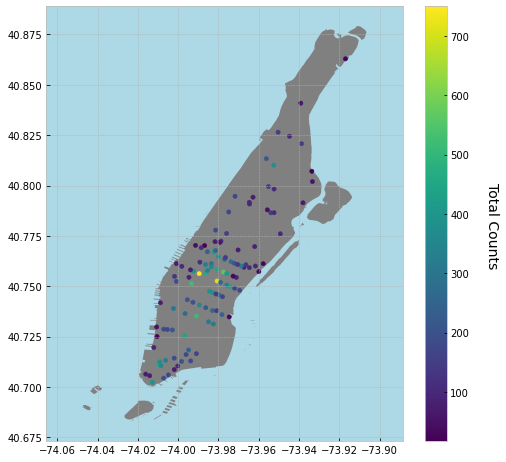

In [ ]:
# -- create a wamp plot of 4 population fit 
fig, ax = plt.subplots(figsize=[8, 8])
boros.plot(color="grey", ax=ax, legend=True)
#parks_m.plot(color="orange", ax=ax, legend=True)
sc = ax.scatter(totalcount["lon"], totalcount["lat"], s=18, c=totalcount["count"])


fig.colorbar(mappable=sc, ax=ax)
ax.set_facecolor("lightblue")
ax.axis("equal")
#ax.set_title("wamp of 4 population fit")
fig.text(0.9, 0.5, "Total Counts", ha="center", 
         va="center", rotation=-90, fontsize=14)



In [ ]:

week = parr[["scl1", "scl2","scl3"]]
wc = week.sum(axis=1)
wc

0      49.246372
1      61.345776
2      75.976533
3      96.801440
4      31.579216
         ...    
111    45.508427
112    69.345897
113    56.381935
114    98.112574
115    49.072208
Length: 116, dtype: float64

Text(1.0, 0.5, 'Tourists Component Relative to the Rest of People')

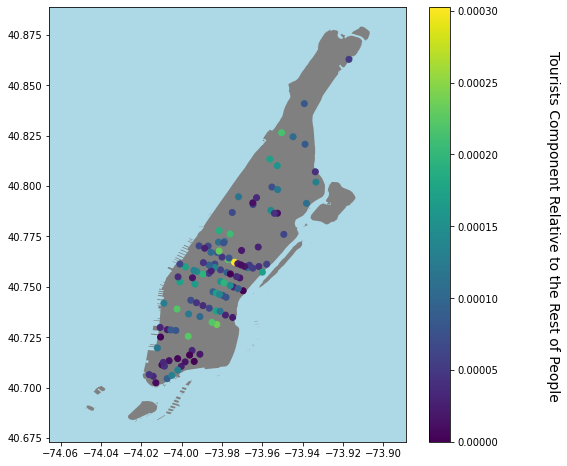

In [ ]:
wa_wc = parr["wamp"]/wc



# -- create a wamp plot of 4 population fit 
fig, ax = plt.subplots(figsize=[8, 8])
boros.plot(color="grey", ax=ax, legend=True)
#parks_m.plot(color="orange", ax=ax, legend=True)
#sc = ax.scatter(wt["lon"], wt["lat"], c=wt["wa_wc"])
sc = ax.scatter(parr["lon"], parr["lat"], c=wa_wc)
fig.colorbar(mappable=sc, ax=ax)
ax.set_facecolor("lightblue")
ax.axis("equal")
#ax.set_title("wamp of 4 population fit")
fig.text(1.0, 0.5, "Tourists Component Relative to the Rest of People", ha="center", 
         va="center", rotation=-90, fontsize=14)
